In [1]:
!pip -q install datasets pandas matplotlib

In [1]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("sms_spam")
df = pd.DataFrame(ds["train"])
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [2]:
print(df.columns)
print(df["label"].value_counts())
df.sample(5, random_state=42)

Index(['sms', 'label'], dtype='object')
label
0    4827
1     747
Name: count, dtype: int64


,sms,label
3690,You still coming tonight?\n,0
3527,"""HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...",0
724,Ya even those cookies have jelly on them\n,0
3370,Sorry i've not gone to that place. I.ll do so ...,0
468,When are you going to ride your bike?\n,0


In [3]:
# rename text column consistently
text_col = "sms" if "sms" in df.columns else ("text" if "text" in df.columns else None)
assert text_col is not None, f"Can't find text column. Columns: {df.columns}"

df = df.rename(columns={text_col: "text"}).copy()
df["text"] = df["text"].astype(str)

print("Missing text:", df["text"].isna().sum())
print("Empty text:", (df["text"].str.strip() == "").sum())

dup_count = df.duplicated(subset=["text", "label"]).sum()
print("Exact duplicates (text+label):", dup_count)

df = df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)
print("After dedupe:", len(df))
print(df["label"].value_counts())


Missing text: 0
Empty text: 0
Exact duplicates (text+label): 403
After dedupe: 5171
label
0    4518
1     653
Name: count, dtype: int64


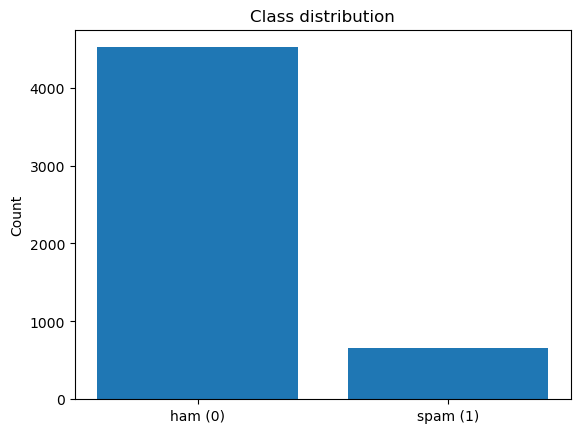

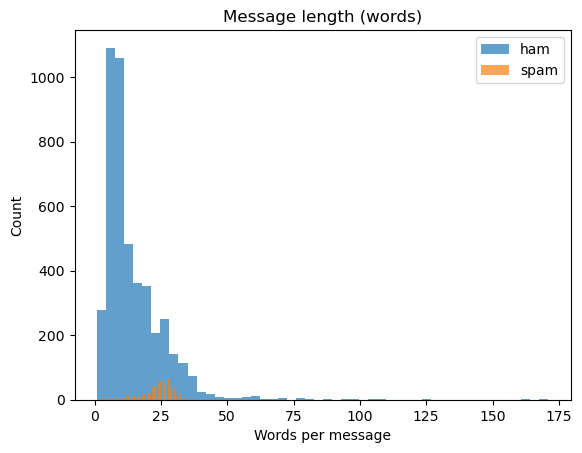

In [4]:
import matplotlib.pyplot as plt

# class distribution
counts = df["label"].value_counts().sort_index()
plt.figure()
plt.bar(["ham (0)", "spam (1)"], [counts.get(0,0), counts.get(1,0)])
plt.title("Class distribution")
plt.ylabel("Count")
plt.show()

# length distribution
df["len_words"] = df["text"].str.split().apply(len)
plt.figure()
plt.hist(df[df["label"]==0]["len_words"], bins=50, alpha=0.7, label="ham")
plt.hist(df[df["label"]==1]["len_words"], bins=50, alpha=0.7, label="spam")
plt.title("Message length (words)")
plt.xlabel("Words per message")
plt.ylabel("Count")
plt.legend()
plt.show()


In [5]:
df.to_csv("data/sms_clean.csv", index=False)
print("Saved -> data/sms_clean.csv")


Saved -> data/sms_clean.csv


In [13]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

Path("data").mkdir(exist_ok=True)

# Save cleaned dataset
df[["text","label"]].to_csv("data/sms_clean.csv", index=False)

# Create ONE reproducible split file (source of truth)
idx = np.arange(len(df))
y = df["label"].astype(int).values

train_idx, temp_idx = train_test_split(idx, test_size=0.30, stratify=y, random_state=42)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.50, stratify=y[temp_idx], random_state=42)

np.savez("data/split_idx.npz", train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)

print("Saved -> data/sms_clean.csv")
print("Saved -> data/split_idx.npz")
print("Sizes:", len(train_idx), len(val_idx), len(test_idx))

Saved -> data/sms_clean.csv
Saved -> data/split_idx.npz
Sizes: 3619 776 776
